In [2]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [3]:
#configuration path Data
path_train_data = "./data/processed/train.json"
path_test_data = "./data/processed/test.json"


In [66]:
#Read Data
import numpy as np
import pandas as pd
train_data = pd.read_json(path_train_data)
test_data = []#pd.read_json(path_test_data)

print("Size of train data:{}, size of test data:{}".format(len(train_data), len(test_data)))


Size of train data:1604, size of test data:0


In [67]:
from IPython.display import display # Allows the use of display() for DataFrames
display(train_data.head())


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [8]:
print(train_data.index)
print(train_data.dtypes)
print(test_data.index)
print(test_data.dtypes)



Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603],
           dtype='int64', length=1604)
band_1        object
band_2        object
id            object
inc_angle     object
is_iceberg     int64
dtype: object
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8414, 8415, 8416, 8417, 8418, 8419, 8420, 8421, 8422, 8423],
           dtype='int64', length=8424)
band_1        object
band_2        object
id            object
inc_angle    float64
dtype: object


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 02:40:20.905952. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [68]:
size_image = len(train_data.iloc[0]['band_1'])
print("size of image in band_1: {}".format(size_image))
width_image = int(np.sqrt(size_image))
print("Shape of image: {}x{}".format(width_image, width_image))


idx_iceberg_td = train_data["is_iceberg"] == 1
idx_ship_td = train_data["is_iceberg"] == 0

num_iceberg_in_train_data = train_data[idx_iceberg_td].shape[0]
print("In train data: percentage of iceberg: {}".format(100 * num_iceberg_in_train_data / train_data.shape[0]))



size of image in band_1: 5625
Shape of image: 75x75
In train data: percentage of iceberg: 46.94513715710723


In [69]:
idx_inc_angle_nan_td = train_data["inc_angle"] == 'na'


print("Number of missing value for inc angle in training: {}".format(train_data[idx_inc_angle_nan_td].shape[0]))
train_data['inc_angle'] = pd.to_numeric(train_data['inc_angle'], errors='coerce')
#idx_inc_angle_nan_td2 = train_data["inc_angle"].isnull()
#idx_inc_angle_nan_td2 == idx_inc_angle_nan_td
print(train_data.dtypes)




Number of missing value for inc angle in training: 133
band_1         object
band_2         object
id             object
inc_angle     float64
is_iceberg      int64
dtype: object


In [5]:
print("Number of missing value for inc angle in training: {}".format(train_data[train_data.inc_angle == np.nan].shape[0]))
 



Number of missing value for inc angle in training: 0


In [12]:
print(train_data.dtypes)

band_1         object
band_2         object
id             object
inc_angle     float64
is_iceberg      int64
dtype: object


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 02:40:41.506313. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
import matplotlib.pyplot as plt
num_show = 10
fig = plt.figure(figsize=(40,40))
for i in range(num_show):
    plt.subplot(num_show,2,2*i + 1)
    img = np.array(train_data[train_data.is_iceberg == 1].iloc[i]['band_1']).reshape(75,75)
    plt.imshow(img)
    plt.subplot(num_show,2,2*i + 2)
    img = np.array(train_data[train_data.is_iceberg == 1].iloc[i]['band_2']).reshape(75,75)
    plt.imshow(img, 'spectral_r')
plt.suptitle('Data with iceberg',fontsize=20)
plt.show()  

//anaconda/envs/udacity-capstone/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


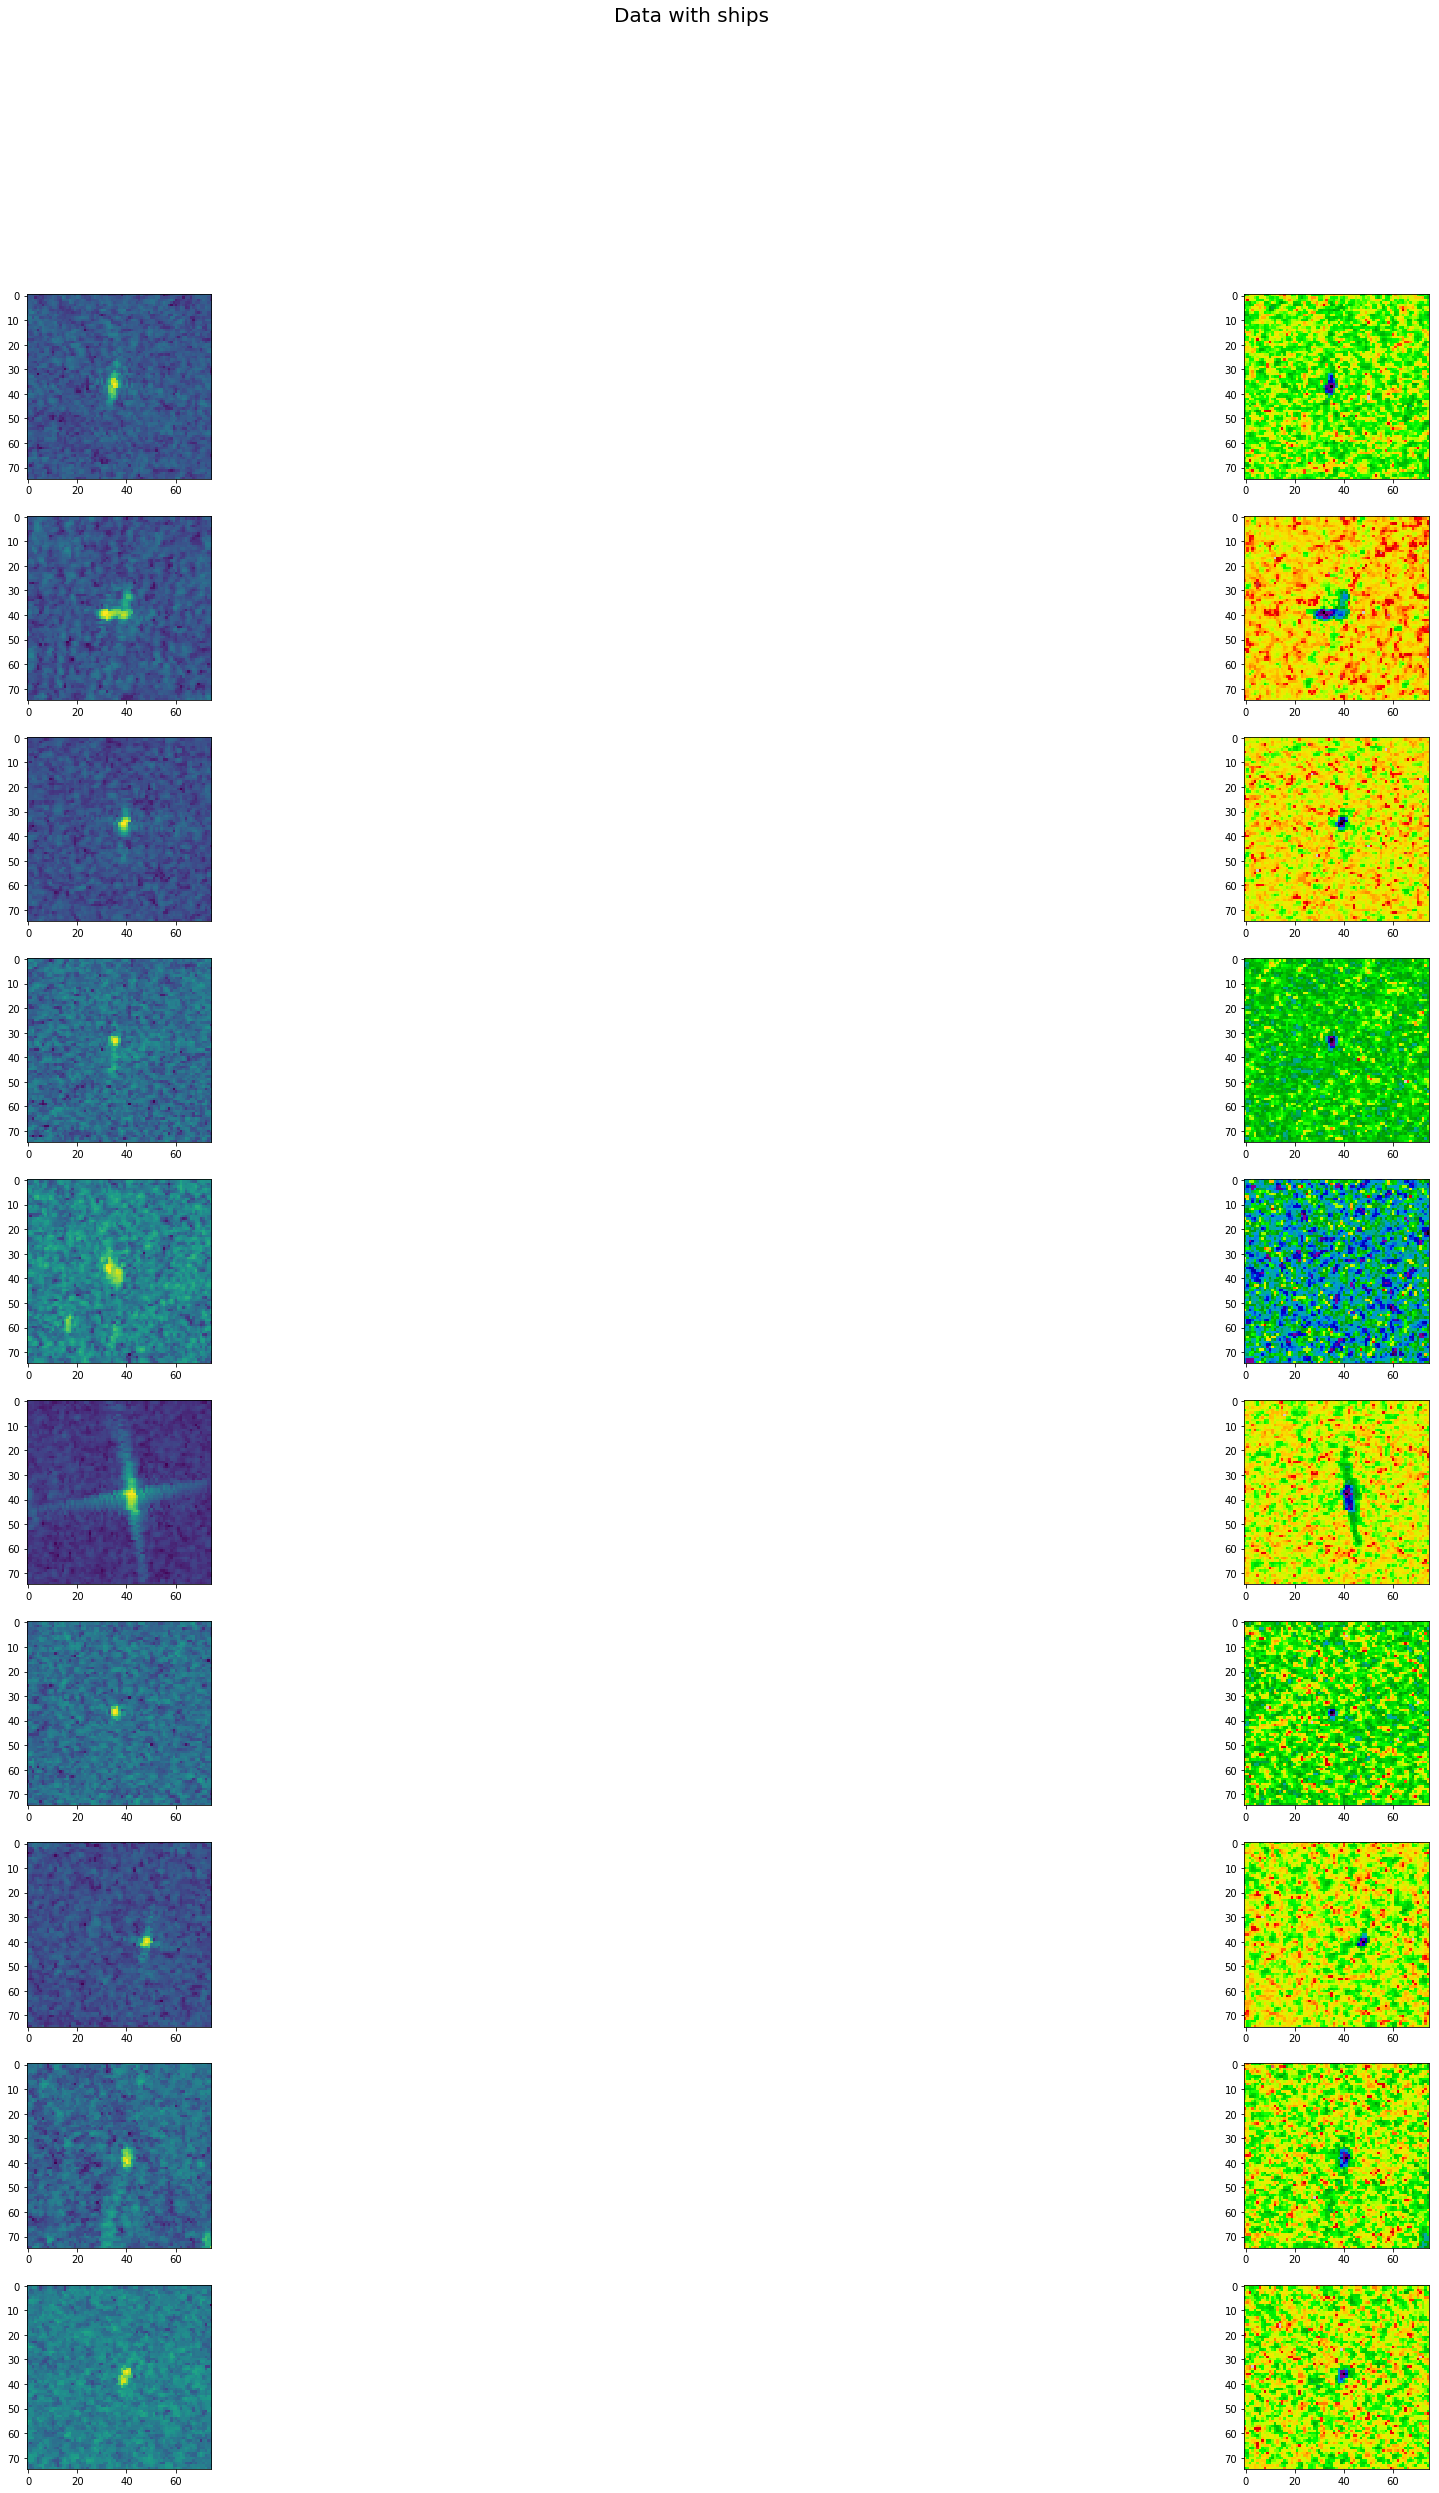

In [48]:
import matplotlib.pyplot as plt
num_show = 10
plt.figure(figsize=(40,40))
for i in range(num_show):
    plt.subplot(num_show,2,2*i + 1)
    img = np.array(train_data[train_data.is_iceberg == 0].iloc[i]['band_1']).reshape(75,75)
    plt.imshow(img)
    plt.subplot(num_show,2,2*i + 2)
    img = np.array(train_data[train_data.is_iceberg == 0].iloc[i]['band_2']).reshape(75,75)
    plt.imshow(img, 'spectral_r')
plt.suptitle('Data with ships',fontsize=20)
plt.show() 

In [70]:
#https://spectraldifferences.wordpress.com/2015/05/06/create-colour-composites-for-alos-palsar-tiles/
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [52]:
rgb_train_data = color_composite(train_data)
rgb_train_data.shape

(1604, 75, 75, 3)

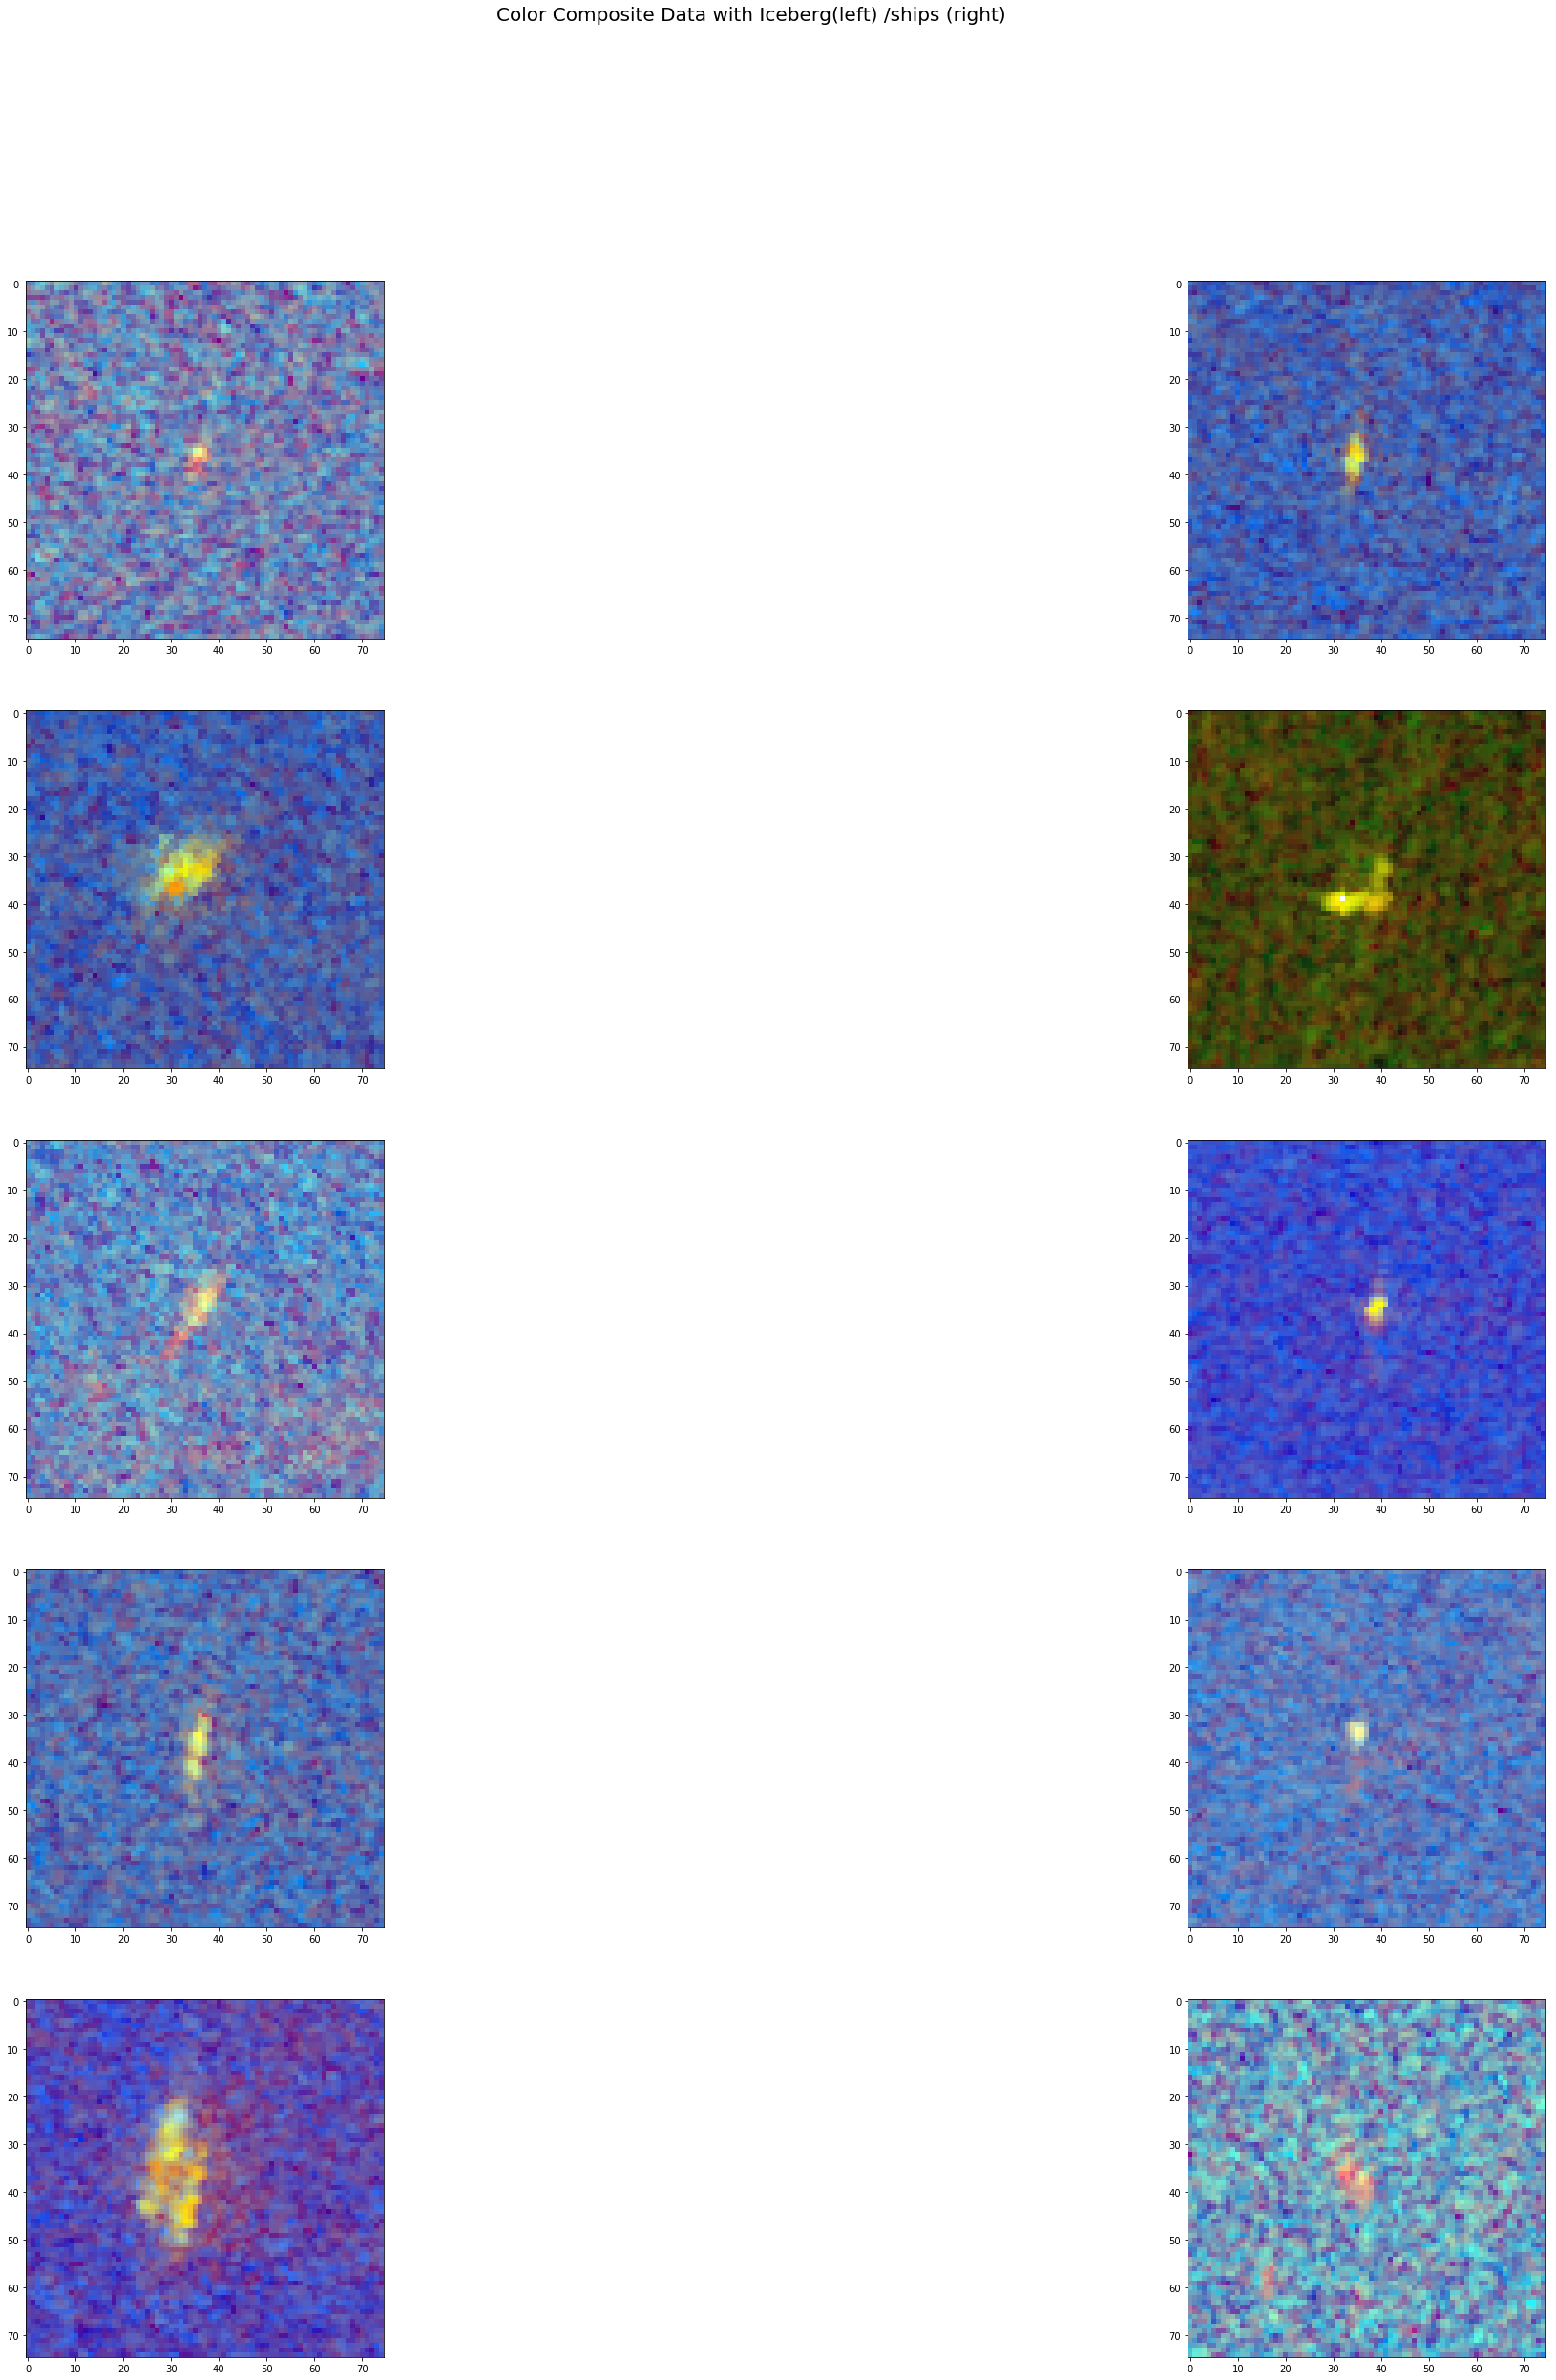

In [61]:
import matplotlib.pyplot as plt
num_show = 5
plt.figure(figsize=(40,40))
for i in range(num_show):
    plt.subplot(num_show,2,2*i + 1)
    img = rgb_train_data[idx_iceberg_td][i]
    plt.imshow(img)
    plt.subplot(num_show,2,2*i + 1 + 1)
    img = rgb_train_data[idx_ship_td][i]
    plt.imshow(img)
plt.suptitle('Color Composite Data with Iceberg(left) /ships (right)',fontsize=20)
plt.show() 

# Learning basic CNN

In [8]:
import mxnet
mxnet.__version__
import keras

Using MXNet backend.
//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:13:12.363633. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [20]:
keras.__version__

'1.2.2'

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 02:43:30.451617. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [95]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:57:20.876304. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [96]:
#define our model
def getModelMxnet():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, 3, 3,activation='relu', input_shape=(3,75, 75)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.1))
    
    #Conv Layer 2
    gmodel.add(Conv2D(128, 3, 3, activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, 3, 3, activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, 3, 3, activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    gmodel.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])
    return gmodel

from IPython.display import clear_output 
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();


def get_callbacksMxnet(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    cs = [es, msave]
    if backend._BACKEND == 'tensorflow':
        tb= TensorBoard(log_dir='./logs_tensorboard', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
        cs += tb
    elif backend._BACKEND == 'mxnet':
        pl = PlotLearning()
        cs.append(pl)

    return cs



//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:57:23.069903. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
def get_X_band(idx, data, fct = None):
    X = np.array([np.array(e).astype(np.float).reshape(75,75) for e in data['band_'+str(idx)]])
    return X

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 02:41:20.313492. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
X_band1 = get_X_band(1, train_data);
print(X_band1.shape)
X_band2 = get_X_band(2, train_data);
print(X_band2.shape)


X_data = np.concatenate([X_band1[:, :, :, np.newaxis], X_band2[:, :, :, np.newaxis], X_band1[:, :, :, np.newaxis]], axis=3)
print(X_data.shape)      

#X_band2 = get_band(2, train_data);
#X_band1[:, :, :, np.newaxis]

#target_train=train_data['is_iceberg']
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

(1604, 75, 75)
(1604, 75, 75)
(1604, 75, 75, 3)


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 02:58:12.556303. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
from sklearn.model_selection import train_test_split 
def prepareDataMxnet():
    target_train=train_data['is_iceberg']
    X_train, X_valid, y_train, y_valid = train_test_split(rgb_train_data, target_train, random_state=1, train_size=0.80)
    X_train = np.swapaxes(X_train, 1,3)
    X_valid = np.swapaxes(X_valid, 1,3)
    
    return (X_train, X_valid, y_train, y_valid)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:13:32.005093. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [29]:
file_path_mxnet = ".model_weights2.mxnet.hdf5"
def fitMxnet(gmodel, X_train, X_valid, y_train, y_valid ):
    callbacks = get_callbacksMxnet(filepath=file_path_mxnet, patience=5)

    return gmodel.fit(X_train, y_train,
          batch_size=32,
          nb_epoch=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

from keras.models import load_model

def followfitMxnet(X_train, X_valid, y_train, y_valid):
    model = load_model(file_path_mxnet)
    model.describe()
    callbacks = get_callbacksMxnet(filepath=file_path, patience=5)

    return gmodel.fit(X_train, y_train,
          batch_size=32,
          nb_epoch=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:40:12.698812. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
model = load_model(file_path_mxnet, False)
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])
    
model.describe()

//anaconda/envs/udacity-capstone/lib/python3.5/site-packages/Keras-1.2.2-py3.5.egg/keras/utils/layer_utils.py:37: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(layer_class.from_config)


ValueError: Shape inconsistent: expected () vs got (1,)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:22:31.249462. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
gmodel=getModelMxnet()
gmodel.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_17 (Convolution2D) (None, 64, 73, 73)    1792        convolution2d_input_7[0][0]      
____________________________________________________________________________________________________
maxpooling2d_17 (MaxPooling2D)   (None, 64, 36, 36)    0           convolution2d_17[0][0]           
____________________________________________________________________________________________________
dropout_25 (Dropout)             (None, 64, 36, 36)    0           maxpooling2d_17[0][0]            
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 128, 34, 34)   73856       dropout_25[0][0]                 
___________________________________________________________________________________________

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:40:21.754192. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
(X_train, X_valid, y_train, y_valid) = prepareDataMxnet()
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(1283, 3, 75, 75)
(321, 3, 75, 75)
(1283,)
(321,)


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:27:22.582356. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


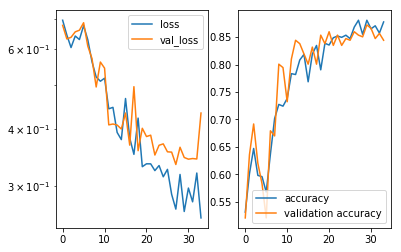

1283/1283 [==============================] - 162s - loss: 0.2552 - acc: 0.8776 - val_loss: 0.4340 - val_acc: 0.8442


//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-17 01:40:34.793239. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [31]:
hist = fitMxnet(gmodel, X_train, X_valid, y_train, y_valid)


In [92]:
hist2 = followfitMxnet(X_train, X_valid, y_train, y_valid)

//anaconda/envs/udacity-capstone/lib/python3.5/site-packages/Keras-1.2.2-py3.5.egg/keras/utils/layer_utils.py:37: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  arg_spec = inspect.getargspec(layer_class.from_config)


ValueError: Shape inconsistent: expected () vs got (1,)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 23:41:53.035880. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [67]:
hist

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-16 22:51:33.587538. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
# import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Learning with pre processing

In [80]:
def pre_process(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)
#mean_img = train_data.mean()
rgb_train_data[:100].shape
rgb_train_data[:100].mean()
np.mean(rgb_train_data[:100])
X_train



NameError: name 'X_train' is not defined

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:30:30.204863. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split 


target_train=train_data['is_iceberg']
X_train_valid, X_test, y_train_valid, y_test = train_test_split(rgb_train_data, train_data['is_iceberg'], random_state=1, train_size=0.90)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, random_state=1, train_size=0.80)
    
X_train = np.swapaxes(X_train, 1,3)
X_valid = np.swapaxes(X_valid, 1,3)
    

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=45.,
                             horizontal_flip=True,
                             vertical_flip=True
                            )

datagen.fit(X_train)
gmodel=getModelMxnet()
gmodel.summary()

file_path_mxnet_preprocess  = ".model_weights_preprocess.mxnet.hdf5"
callbacks = get_callbacksMxnet(filepath=file_path_mxnet_preprocess, patience=5)


gmodel.fit_generator(datagen.flow(X_train, y_train),
                    X_train.shape[0],
                    100,
                    validation_data=(X_valid, y_valid),
                    callbacks=callbacks
                    )


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_33 (Convolution2D) (None, 64, 73, 73)    1792        convolution2d_input_9[0][0]      
____________________________________________________________________________________________________
maxpooling2d_33 (MaxPooling2D)   (None, 64, 36, 36)    0           convolution2d_33[0][0]           
____________________________________________________________________________________________________
dropout_49 (Dropout)             (None, 64, 36, 36)    0           maxpooling2d_33[0][0]            
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 128, 34, 34)   73856       dropout_49[0][0]                 
___________________________________________________________________________________________

//anaconda/envs/udacity-capstone/lib/python3.5/site-packages/mxnet/module/bucketing_module.py:385: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.03125). Is this intended?
  force_init=force_init)


 544/1090 [=============>................] - ETA: 69s - loss: 0.7028 - acc: 0.5515 

In [99]:
help(gmodel.fit_generator)

Help on method fit_generator in module keras.models:

fit_generator(generator, samples_per_epoch, nb_epoch, verbose=1, callbacks=None, validation_data=None, nb_val_samples=None, class_weight=None, max_q_size=10, nb_worker=1, pickle_safe=False, initial_epoch=0, **kwargs) method of keras.models.Sequential instance
    Fits the model on data generated batch-by-batch by
    a Python generator.
    The generator is run in parallel to the model, for efficiency.
    For instance, this allows you to do real-time data augmentation
    on images on CPU in parallel to training your model on GPU.
    
    # Arguments
        generator: a generator.
            The output of the generator must be either
            - a tuple (inputs, targets)
            - a tuple (inputs, targets, sample_weights).
            All arrays should contain the same number of samples.
            The generator is expected to loop over its data
            indefinitely. An epoch finishes when `samples_per_epoch`
        

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 01:00:13.208605. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Improvement

- Use of Incident angle
- Batch normalization
- Use Data augmentation
- Use spekkle filtering

In [91]:
X_train.shape
X_valid.shape
X_test.shape





(241, 75, 75, 3)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:51:38.819467. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [86]:
X_valid.shape

(321, 3, 75, 75)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:49:56.932755. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [87]:
X_test.shape

(321, 75, 75, 3)

//anaconda/envs/udacity-capstone/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2018-01-19 00:50:08.651626. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
